In [1]:
import numpy as np
from numpy import Inf
import sys

##  exp
sys.path.append("/u/svarel/exp/build/utils/Analysis/")
from spherical_basis_builder import *
import simpleSL

## Auriga
import LibAu as la


# Load Halo with LibAu.py
We use <code>LibAu</code> a complementary code based in Marinacci code to read Auriga Data. From this code we obtain General parameters of simulation such as hubble parameter and scalefactor. Also we can obtain data information of the halo such as 
<blockquote>
    <ul>
        <li>$\rm M_{200}$  ---> Total mass of the halo enclosed in a sphere whose mean
density is 200 times the critical density of the Universe</li>
        <li>$\rm R_{200}$  ---> Radius that enclosed $\rm M_{200}$</li>
        <li>$N_{part}$     ---> List of number of particles of each component of each subhalo (gas,DM,stars,BH, and <b>item 0 correspond to central subhalo</b>)</li>
    </ul>

</blockquote>
For this example we use Au-21 halo in the snapshot 63 (in this snapshot the redshift is z=0 and scalefactor is 1). Here we use the functions from LibAu in order to read the particles (stars and DM) of the central subhalo, which in this case its index is 0 for various parameters.

<b>First we load stars particles</b>

We load the position ('pos'; kpc), velocities ('vel'; km/s),ID of particles ('id') , masses ('mass'; $\rm M_\odot$), type of particle ('type'), potential('pot'; $(km/s)^2$), age of stars('age';Gyr) of the central subhalo (<b>idSubhalo=0</b>)
<blockquote>

```python
fields_stars = ['pos','vel','id','mass','type','pot','age']    
Datstars = sim.Snapshot_Subhalo(idSubhalo=0,snapType='stars',fields=fields_stars)
```

</blockquote>

<b>Then we load DM particles</b>

We load the position ('pos'; kpc), velocities ('vel'; km/s),ID of particles ('id') , masses ('mass'; $\rm M_\odot$), type of particle ('type'), potential('pot'; $(km/s)^2$) of the central subhalo (<b>idSubhalo=0</b>) and also we select the best resolution in Dark matter (<b>snapType='dm1'</b>)
<blockquote>

```python
fields_dm = ['pos','vel','id','mass','type','pot']
DatDM = sim.Snapshot_Subhalo(idSubhalo=0,snapType='dm1',fields=fields_dm)
```

</blockquote>

### Preparing the data halo

For this example we use the stars particles to rotate de halo, in this way the halo is aligned with the angular momentum of the particles of the stellar component. Also this routine is need for futures analisys. 

We used <code>gal.Rotate()</code> from <code>LibAu.ToolRot</code> class to rotate the halo. The code rotate the halo using young stars. Then the DM component is rotated simultaneously with the rotation of the stellar component.
<blockquote>

```python
Data = {'stars':Datstars,'dm1':DatDM}
param = {'spos':sim.sf.data['spos'][0,:],'svel':sim.sf.data['svel'][0,:],'header':sim.Header()}
gal = la.ToolRot(Data=Data, param=param)
Data = gal.Rotate()

```

</blockquote>




In [2]:
nhalo=21 #Name Halo
nsnap= 63 #z=0
sim = la.Reader_Au(Nhalo=nhalo,Nsnap=nsnap) #Read Simulation
header = sim.Header()
h=header['hubbleparam']
sc=header['time']

Rvir =sim.sf.data['frc2'][0]*1000*sc/h
Mvir =sim.sf.data['fmc2'][0]*1e10/h
Npart = sim.sf.data['slty'][0]
print(Mvir,Rvir,Npart)

fields_stars = ['pos','vel','id','mass','type','pot','age']
Datstars = sim.Snapshot_Subhalo(idSubhalo=0,snapType='stars',fields=fields_stars)


fields_dm = ['pos','vel','id','mass','type','pot']
DatDM = sim.Snapshot_Subhalo(idSubhalo=0,snapType='dm1',fields=fields_dm)
#Rotate Halo
Data = {'stars':Datstars,'dm1':DatDM}
param = {'spos':sim.sf.data['spos'][0,:],'svel':sim.sf.data['svel'][0,:],'header':sim.Header()}
gal = la.ToolRot(Data=Data, param=param)
Data = gal.Rotate()

Datstars=Data['stars']
DatDM = Data['dm1']

potdm = DatDM['pot']

2088654433553.4023 349.25210558595916 [11792260 31503466        0        0 19107866        1]


/u/svarel/.local/lib/python3.6/site-packages/cosmological_factors.py:100: RuntimeWarning: invalid value encountered in sqrt
  var2 = np.sqrt(self.OmegaLambda / self.OmegaMatter * a**3.0)


<b>General information of the halo</b>

In [3]:
print('IDhalo: Au-%s'%nhalo)
print('Nsnap: %s'%nsnap)
print('R200: %.3f kpc'%Rvir)
print('M200: %.3f Msun'%np.log10(Mvir))
print('Ngas: %e '%Npart[0])
print('Ndm: %e '%Npart[1])
print('Nstar: %e '%Npart[4])
print('Ntot: %e '%(np.sum(Npart)-1))

IDhalo: Au-21
Nsnap: 63
R200: 349.252 kpc
M200: 12.320 Msun
Ngas: 1.179226e+07 
Ndm: 3.150347e+07 
Nstar: 1.910787e+07 
Ntot: 6.240359e+07 


# Empirical Bases Computation

In this test, we use $\rm 10^6$ random particles from DM halo. These particles are used to perform a spherical density profile:

<blockquote>

```python
rbins,dreturn = return_density(np.log10(rr), 1., rangevals=[0., 2.5],bins=100)
```
<b>Input</b>
    <ul>
        <li><code>np.log10(rr)</code> is an array of radial position of the particles in logaritmic scale.</li>
        <li><code>1</code> is the value of the DM particles, which all this particles have the same mass.</li>
        <li><code>rangevals=[0., 2.5]</code> : range of values of the radial part, in logaritmic scale</li>
        <li><code>bins=100</code>: number of bins or spherical shells for density profile.</li>
    </ul>

<b>Output</b>
    <ul>
        <li><code>rbins</code> Radial position of the spherical shell</li>
        <li><code>dreturn</code> The corresponding spherical DM density in function of radii.</li>
    </ul>
</blockquote>

### Empirical model
The empirical model is built using the spherical density profile previously calculated. The empirical model code return parameters such as radius, density of DM mass, mass enclosed and potential gravity enclosed, which all these parameters are normalized by the virial mass and radius.  

<blockquote>

```python
R,D,M,P = makemodel_empirical(rbins, dreturn, M=1.,pfile='m12b_SPHLbasis_empirical.txt')
```
<b>Input</b>
    <ul>
        <li><code>rbins</code> Radial position of the spherical shell</li>
        <li><code>dreturn</code> The corresponding spherical DM density in function of radii.</li>
        <li><code>M=1</code> #######</li>
        <li><code>pfile='m12b_SPHLbasis_empirical.txt</code> File where the results are saved</li>
    </ul>

<b>Output</b>
    <ul>
        <li><code>R</code> the radius values</li>
        <li><code>D</code> the density</li>
        <li><code>M</code> the mass enclosed</li>
        <li><code>P</code> the potential</li>
    </ul>
</blockquote>

### Build the basis


<blockquote>

```python
ebf = simpleSL.slfunctions('./m12b_SPHLbasis_empirical.txt',5,10,0.,2.5, 2000)
```
<b>Input</b>
    <ul>
        <li><code>'./m12b_SPHLbasis_empirical.txt'</code> modelfile: path empirical model that contains R,D,M,P normalized by virial parameters.</li>
        <li><code>LMAX</code></li>
        <li><code>NMAX</code></li>
        <li><code>logxmin</code> minimal radial value in log scale</li>
        <li><code>logxmax</code> maximal radial value in log scale</li>
        <li><code>numr</code>  Number of elements(?)</li>
    </ul>

<b>Output</b>
    <ul>
        <li><code>ebf</code> empirical basis function [m,n] (harmonics subspaces and radial order, respec.)</li>
     </ul>
</blockquote>

### Compute the coefficients 


<blockquote>

```python
coefficients = simpleSL.coefsl(mass,pos[:,0],pos[:,1],pos[:,2],'./m12b_SPHLbasis_empirical.txt',2,6)    
```
<b>Input</b>
    <ul>
        <li><code>mass</code> DM mass particles of the halo</li>
        <li><code>pos[:,0],pos[:,1],pos[:,2]</code> 3D position of each DM particle.</li>
        <li><code>'./m12b_SPHLbasis_empirical.txt'</code> modelfile: path empirical model that contains R,D,M,P normalized by virial parameters.</li>
        <li><code>??</code></li>
        <li><code>??</code></li>
   </ul>

<b>Output</b>
    <ul>
        <li><code>coefficients</code> </li>
     </ul>
</blockquote>

In [4]:
pos = DatDM['pos'] #part_rot[not_in_subs]
mass = DatDM['mass']  #part['dark']['mass'][not_in_subs]
print(np.sum(mass), mass[0], len(pos), len(mass))
M_tot = np.sum(mass)

#selecting 1million random particles
ind = np.arange(0,len(mass),1,dtype=int)
sel = np.random.choice(ind, 1000000, replace=False).astype(int)
pos,mass = pos[sel],mass[sel]
potdm=potdm[sel]

Mfac = M_tot/np.sum(mass)
mass = mass*Mfac

rr = np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)
rrmax=np.nanmax(np.log10(rr))
rbins,dreturn = return_density(np.log10(rr), 1., rangevals=[0., rrmax],bins=100)
R,D,M,P = makemodel_empirical(rbins, dreturn, M=1.,pfile='m12b_SPHLbasis_empirical.txt')
'''
R           : (array of floats) the radius values
D           : (array of floats) the density
M           : (array of floats) the mass enclosed
P           : (array of floats) the potential'''

# Build the basis
ebf = simpleSL.slfunctions('./m12b_SPHLbasis_empirical.txt',5,10,0.,2.5, 2000)

# Compute the coefficients using the empirical basis function ebf
coefficients = simpleSL.coefsl(mass, pos[:,0], pos[:,1], pos[:,2],  './m12b_SPHLbasis_empirical.txt',5,10)
print(np.shape(ebf))
print(np.shape(coefficients))
print(pos[:,0])


1909857200000.0 60622.2 31503466 31503466
! Scaling:  R= 719.5695393262961   M= 1.0   M0= 997813.1731637323   R0= 719.5695393262961
1.0 1.0021916195286677e-06 1.002191619528668e-06 1.0021916195286679e-06
(36, 10, 2000)
(36, 10)
[  11.767157   55.22987   -25.788757 ... -184.22502  -389.283
    9.098372]


simpleSL.slfunctions

Docstring:
slfunctions(modelfile: str, LMAX: int = 6, NMAX: int = 20, logxmin: float = -3, logxmax: float = 0.5, numr: int = 2000) -> List[numpy.ndarray[numpy.float64[m, n]]]

Basic SLfunction exposure
Type:      builtin_function_or_method

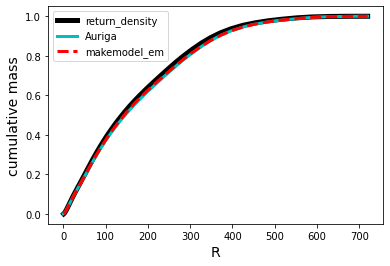

In [5]:
#pos,mass
#Ordeno datos de Auriga
rbord = np.argsort(rr)
rb,mb,pwau = rr[rbord],mass[rbord],potdm[rbord]
ran = (rb<=rbins[-1])
rb,mb,pwau = rb[ran],mb[ran],pwau[ran] #Datos directamente de Auriga
mbacc = np.cumsum(mb)
#########################################################
#datos de return_density
dm = (4/3)*np.pi*dreturn*rbins**3
dm2 = 2*np.pi*(rbins**2)*dreturn*(rbins[1]-rbins[0])
Macc = np.cumsum(dm)


rmax = np.nanmax(rbins)
plt.subplot(111)
plt.plot(rbins,Macc/Macc[-1],color='k',label='return_density',lw=5)
plt.plot(rb,mbacc/mbacc[-1],color='c',label='Auriga',lw=3,ls='-')
plt.plot(R, M,c='r',ls='--', label='makemodel_em',lw=3)
plt.legend()
plt.ylabel('cumulative mass',fontsize=14)
plt.xlabel('R',fontsize=14)
plt.savefig('plots/CumMassMakemodel_em.pdf')

4.5433154170959243e-39


Text(0.5, 0, 'R')

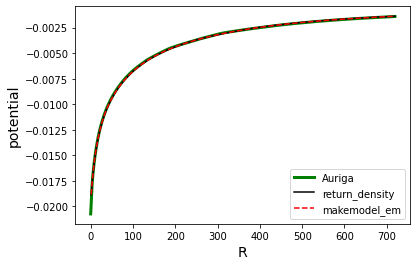

In [6]:
G= 6.674*1e-11 #m3⋅kg−1⋅s−2
m2kpc, kg2Msun = 3.2408*1e-20,5e-31
G=G*(m2kpc**3) /kg2Msun # kpc3 Msun-1 s-2
print(G)
#pvals = -mvals/(rvals+1.e-10) - (pwvals[dvals.size-1] - pwvals)

pwau_ = pwau*(3.24078e-17)**2 /G# (1/(G*mbacc[-1]) )
pwauacc = ((-mbacc/rb) - (np.sum(pwau_)-np.cumsum(pwau_)))#  *(rb[-1]/mbacc[-1])
Potau = ((-mbacc/rb) - (np.sum(mb/rb)-np.cumsum(mb/rb))) *(1/mbacc[-1]) # <----------

Pw = dm/rbins
Pwacc = ((-Macc/rbins) - (np.sum(Pw)-np.cumsum(Pw)))  *(1/Macc[-1])
plt.subplot(111)

plt.plot(rb,Potau,color='g',label='Auriga',lw=3)
plt.plot(rbins,Pwacc,color='k',label='return_density')
plt.plot(R, P,c='r',ls='--', label='makemodel_em')
plt.legend()
plt.ylabel('potential',fontsize=14)
plt.xlabel('R',fontsize=14)

Text(0.5, 1.0, 'Auriga - mb/rb')

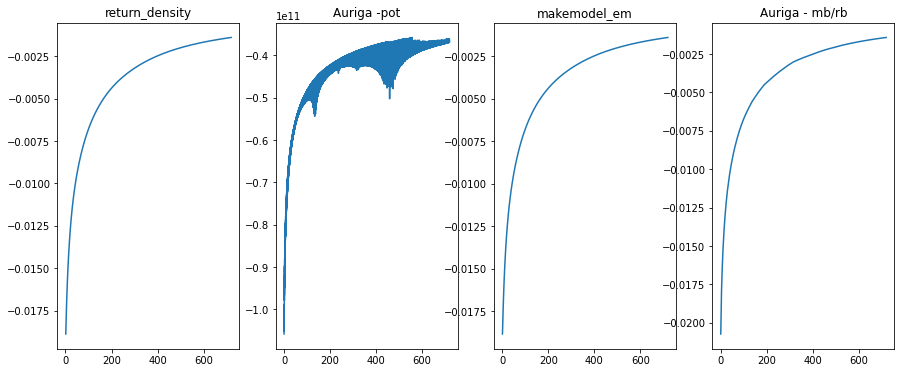

In [7]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.plot(rbins,Pwacc,label='return_density')
plt.title('return_density')

plt.subplot(142)
pwauacc = np.cumsum(pwau) *1/(mbacc[-1])
plt.title('Auriga -pot')
plt.plot(rb,pwau_,label='b')


plt.subplot(143)
#plt.plot(rb,-(np.cumsum(mb/mb)/( (3/4)*np.pi*rb) ))
plt.plot(R,P)
plt.title('makemodel_em')

plt.subplot(144)
plt.plot(rb,Potau)
plt.title('Auriga - mb/rb')


' Al calcular M/r para el potencial gravitacional, se acerca mas al parametro Potential si \nuso todas las DM particles.\nProbablemente si uso gas y stars particles podria obtener el mismo parametro\n'

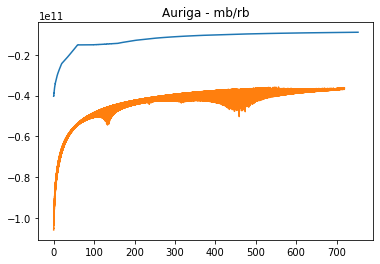

In [8]:
postot = DatDM['pos']
masatot = DatDM['mass']
rr_tot = np.sqrt(postot[:,0]**2 + postot[:,1]**2 + postot[:,2]**2)
ortot = np.argsort(rr_tot)
masatotacc,rr_tot = np.cumsum(masatot[ortot]),rr_tot[ortot]
pottotal = ((-masatotacc/rr_tot) - (np.sum(masatot[ortot]/rr_tot)-np.cumsum(masatot[ortot]/rr_tot)))
plt.plot(rr_tot,pottotal)
plt.plot(rb,pwau_)#* (1/mbacc[-1]))
plt.title('Auriga - mb/rb')
''' Al calcular M/r para el potencial gravitacional, se acerca mas al parametro Potential si 
uso todas las DM particles.
Probablemente si uso gas y stars particles podria obtener el mismo parametro
'''

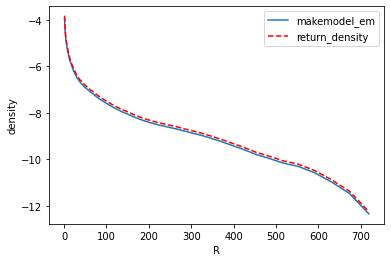

In [9]:
km2kpc = 3.24078e-17

plt.subplot(111)
plt.plot(R, np.log10(D), label='makemodel_em')
plt.plot(rbins,np.log10(dreturn*(2*np.pi/np.sum(dm))),c='r',ls='--',label='return_density')

plt.ylabel('density')
plt.xlabel('R')
plt.legend()


(36, 10, 2000)


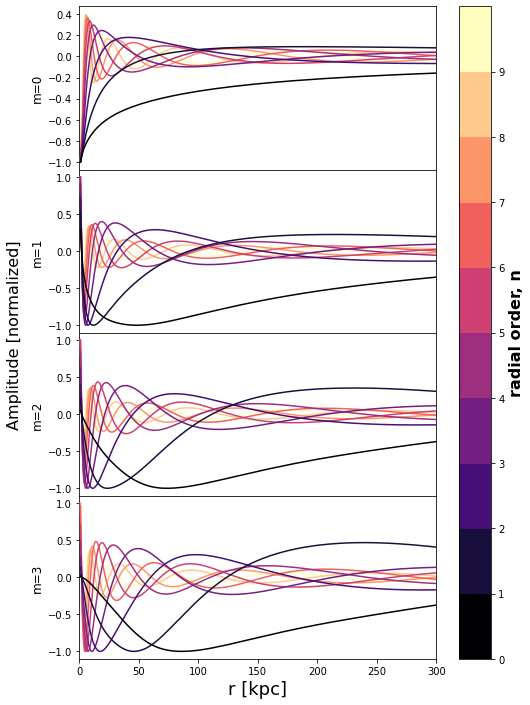

In [10]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
print(np.array(ebf).shape)
N= 10
colors =plt.get_cmap('magma', N)# plt.cm.hot(np.linspace(0,1,N))

xvals = 10.**(np.linspace(0,2.5, 2000))

fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(8,12))
plt.subplots_adjust(hspace=0)
for m in range(4):
    #plt.subplot(4,1,m+1)
    #ax=fig.add_subplot(4,1,m+1)
    for n in range(0,10):
        ax[m].plot(xvals, ebf[m][n]/np.max(np.abs(ebf[m][n])),c=colors(n),label='n = %s'%n,zorder=N-n)
        ax[m].set_ylabel('m=%s'%m,fontsize=12)
        ax[m].set_xlim(0,300)
        if m!=3:ax[m].set_xticks([])
#plt.legend(title='radial order',fontsize=14,title_fontsize=18)

norm = mpl.colors.Normalize(vmin=0, vmax=N)
sm = plt.cm.ScalarMappable(cmap=colors, norm=norm)
sm.set_array([])  
#cbar_ax = fig.add_axes([0.5, 0.15, 0.5, 0.7])

cb=plt.colorbar(sm,ax=ax.ravel().tolist(), ticks=np.arange(0, N, 1))
cb.set_label(label='radial order, n', size=16, weight='bold')
plt.xlabel('r [kpc]',fontsize=18)

fig.text(0.00, 0.5, 'Amplitude [normalized]', va='center', rotation='vertical',fontsize=16)

#plt.subplots_adjust(hspace=0.1)
plt.show()
plt.close()

In [11]:
from exptool.utils import halo_methods
from exptool.basis import spheresl
from schwimmbad import SerialPool,MultiPool
def compute_density(coordinates, expcoef):
    # den0 is the monopole contribution to the density
    # den1 is the l>0 contribution to the densityx`
    # (therefore, the total density is den0+den1)
    # pot0 is the monopole contribution to the potential
    # pot1 is the l>0 contribution to the potential
    # potr is the radial force
    # pott is the polar force
    # potp is the azimutuhal force

    # specify your cache generated by simpleSL
    sph_file = './.slgrid_sph_cache'

    # specify your spherical model file (input to simpleSL)
    mod_file = './m12b_SPHLbasis_empirical.txt'

    # pull in the cache data
    lmax, nmax, numr, cmap, rmin, rmax, scale, ltable, evtable, eftable = halo_methods.read_cached_table(sph_file)
    xi, rarr, p0, d0 = halo_methods.init_table(mod_file, numr, rmin, rmax, cmap, scale)

    # specify the coefficient array: you will not have to do this, because you already have the coefficients in the correct format
    # from simpleSL.coefsl()
    #llmax = (lmax+1)*(lmax+1)
    #expcoef = np.zeros([llmax,nmax])

    # make some mock coefficient values
    #expcoef[0][0] = 6.0
    #expcoef[1][0] = 0.01

    # specify coordinate
    #r     = 0.01 # 3d radius
    #costh = 0.0  # = z/r, polar coordinate
    #phi   = 0.0  # azimuth
    r, costh, phi = coordinates[0], coordinates[1], coordinates[2]
    # evaluate fields at a specifc point
    den0,den1,pot0,pot1,potr,pott,potp = spheresl.all_eval(r, costh, phi, expcoef,xi,p0,d0,cmap,scale,lmax,nmax,evtable,eftable)
    return den0, den1,pot0,pot1
class Reconstruction:
    def __init__(self,expcoef):
        
        # specify your cache generated by simpleSL
        sph_file = './.slgrid_sph_cache'
        # specify your spherical model file (input to simpleSL)
        mod_file = './m12b_SPHLbasis_empirical.txt'
        
        # pull in the cache data
        cached_table = halo_methods.read_cached_table(sph_file)
        self.lmax, self.nmax, self.numr, self.cmap, self.rmin, self.rmax, self.scale, self.ltable, self.evtable, self.eftable = cached_table
        
        self.xi, self.rarr, self.p0, self.d0 = halo_methods.init_table(mod_file, 
                                                                       self.numr, self.rmin, 
                                                                       self.rmax, self.cmap, self.scale)
        self.expcoef=expcoef
    
    def AllEval(self,coordinates,verbose=True):
        r, costh, phi,c,T = coordinates
        #print(str(round(c/T,2)),end='\r')
        if verbose==True:la.PrintPercent(c,T,typ='fraper',text='AllEval')
        den0,den1,pot0,pot1,potr,pott,potp = spheresl.all_eval(r, costh, phi, 
                                                               self.expcoef,self.xi,self.p0,self.d0,
                                                               self.cmap,self.scale,self.lmax,self.nmax,
                                                               self.evtable,self.eftable)
        return den0, den1,pot0,pot1

    def DenPot(x):
        ri,phii,thetai = x#rpos[i],phi[i],theta[i]
        print(r)
        den_pot = compute_density([ri, thetai, phii], coefficients)
        return den_pot

In [12]:
import exptool.basis as test
test.__file__

'/u/svarel/.local/lib/python3.6/site-packages/exptool/basis/__init__.py'

In [13]:
postemp=np.copy(pos)
rpos =  np.sqrt(postemp[:,0]**2 + postemp[:,1]**2 + postemp[:,2]**2)
phi =  np.arctan2(postemp[:,1], postemp[:,0])
theta = np.arctan(postemp[:,2], postemp[:,0])
Dmon,Dnmon,Pmon,Pnmon= np.zeros_like(rpos),np.zeros_like(rpos),np.zeros_like(rpos),np.zeros_like(rpos)
del postemp

Rec =  Reconstruction(coefficients)
C,T=np.array(range(len(rpos))),len(rpos)*np.ones_like(rpos)
#pool = SerialPool()#MultiPool(processes=8)#
print(pos[:,0],pos[:,0].shape)
#pool.close()
#for i in range(len(rpos)):
#    ri,phii,thetai = rpos[i],phi[i],theta[i]
#    dmon,dnmon,pmon,pnmon= compute_density([ri, thetai, phii], coefficients)
#    Dmon[i],Dnmon[i],Pmon[i],Pnmon[i]=dmon,dnmon,pmon,pnmon


[  11.767157   55.22987   -25.788757 ... -184.22502  -389.283
    9.098372] (1000000,)


In [14]:
values=0
print(values)
with SerialPool() as pool:
    values = np.array(list(pool.map(Rec.AllEval, zip(rpos,phi,theta,C,T) )))
print(values)

0


/u/svarel/.local/lib/python3.6/site-packages/exptool/basis/spheresl.py:731: RuntimeWarning: invalid value encountered in sqrt
  somx2 = np.sqrt( (1.0 - x)*(1.0 + x) );


[[ 1.41843178e+04 -4.99280940e+04 -9.91189399e+09  1.39918331e+08]1m-==> 999999/1000000.0 - 100.0%-AllEval
 [ 1.02631405e+05  1.01849579e+05 -1.52728476e+10 -1.54052497e+08]
 [ 2.25178247e+04 -8.09978294e+05 -1.10542998e+10  4.74226657e+09]
 ...
 [ 1.24265787e+02 -2.85303111e+03 -3.77606958e+09  5.53292226e+08]
 [ 3.47160010e+01 -8.14360214e+02 -3.26062636e+09  4.85580843e+08]
 [ 7.57841050e+04  2.12301569e+04 -1.43575040e+10  3.57387457e+08]]


In [15]:
values.shape

(1000000, 4)

In [16]:
pos[:,0],pos[:,0].shape

(array([  11.767157,   55.22987 ,  -25.788757, ..., -184.22502 ,
        -389.283   ,    9.098372], dtype=float32),
 (1000000,))

import h5py
tx = h5py.File('Table/CacheAllEval.hdf5','w')
tx.create_dataset('values', data=values)
tx.close()

import h5py
tx = h5py.File('Table/CacheAllEval.hdf5','r')
values = tx['values']

In [17]:
den0, den1,pot0,pot1 = values[:,0], values[:,1], values[:,2], values[:,3]
rpos =  np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)
M0,M1 = den0*((4*np.pi*rpos**3)/3),den1*((4*np.pi*rpos**3)/3)

In [18]:
Npx=100
Hden,Hpot,Hpotmed = np.zeros((Npx,Npx)),np.zeros((Npx,Npx)),np.zeros((Npx,Npx))
den_mon,den_nonmon = np.zeros((Npx,Npx)),np.zeros((Npx,Npx))
pot_mon,pot_nonmon = np.zeros((Npx,Npx)),np.zeros((Npx,Npx))
xb,yb=np.linspace(pos[:,0].min(), pos[:,0].max(),Npx),np.linspace(pos[:,1].min(), pos[:,1].max(),Npx)
dx,dy= xb[1]-xb[0],yb[1]-yb[0]
xgrid, ygrid = np.meshgrid(xb, yb)

rbord = np.argsort(rr)
rb,mb = rr[rbord],mass[rbord]
rbord1=np.argsort(rbord)
mbacc = np.cumsum(mb)
Pot_au=  ((-mbacc/rb) - (np.sum(mb/rb)-np.cumsum(mb/rb)))[rbord1]

for j in range(yb.size -1):
    for i in range(xb.size-1):
        sel = (xb[i]<=pos[:,0])&(pos[:,0]<=xb[i+1]) & (yb[j]<=pos[:,1])&(pos[:,1]<=yb[j+1])
        if len(pos[:,2][sel])>0:
            dz = np.nanmax(pos[:,2][sel])-np.nanmin(pos[:,2][sel])
            Hden[j][i] = np.sum(mass[sel])/(dx*dy*dz)
            den_mon[j][i],den_nonmon[j][i]=np.median(den0[sel]),np.median(den1[sel])
            
            Hpot[j][i] = np.sum(Pot_au[sel])/(dx*dy*dz)#potdm
            Hpotmed[j][i] = np.median(Pot_au[sel])#potdm
            pot_mon[j][i],pot_nonmon[j][i]=np.median(pot0[sel]),np.median(pot1[sel])
        else: pass

/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


Npx=25
x = np.linspace(pos[:,0].min(), pos[:,0].max(),Npx+1)
y = np.linspace(pos[:,1].min(), pos[:,1].max(),Npx+1)
dx,dy= x[1]-x[0],y[1]-y[0]
xgrid, ygrid = np.meshgrid(x, y)


rbord = np.argsort(rr)
rb,mb = rr[rbord],mass[rbord]
rbord1=np.argsort(rbord)
mbacc = np.cumsum(mb)
Pot_au=  ((-mbacc/rb) - (np.sum(mb/rb)-np.cumsum(mb/rb)))[rbord1]

den_mon = np.zeros_like(xgrid)
den_nonmon = np.zeros_like(xgrid)

pot_mon = np.zeros_like(xgrid)
pot_nonmon = np.zeros_like(xgrid)

Hden,Hpot,Hpotmed= np.zeros_like(xgrid),np.zeros_like(xgrid),np.zeros_like(xgrid)

for i in range(Npx-1):
    for j in range(Npx-1):
        xcen,ycen = xgrid[i][j]+dx , ygrid[i][j]+dy
        r = (xcen**2 + ycen**2)**0.5
        phi = np.arctan2(ycen, xcen)
        theta=np.arctan2(zcen, xcen)
        den_mon[i][j], den_nonmon[i][j],pot_mon[i][j],pot_nonmon[i][j] = compute_density([r, 0, phi], coefficients)
        
        sel= (xcen-dx<=pos[:,0])&(pos[:,0]<=xcen+dx) & (ycen-dy<=pos[:,1])&(pos[:,1]<=ycen+dy)
        Hden[i][j] = np.sum(mass[sel])/(dx*dy)
        Hpot[i][j] = np.sum(Pot_au[sel])/(dx*dy)#potdm
        Hpotmed[i][j] = np.median(Pot_au[sel])#potdm

#Xgrid = rgrid * np.cos(thetagrid)potdm
#Ygrid = rgrid * np.sin(thetagrid)
    
#fig, ax = plt.subplots(1, 1)
#ax.contourf(xgrid, ygrid, np.log10(np.abs(den_mon + den_nonmon)))
#fig.savefig("2d_density.png", bbox_inches='tight')
#plt.show()
#plt.close()

/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


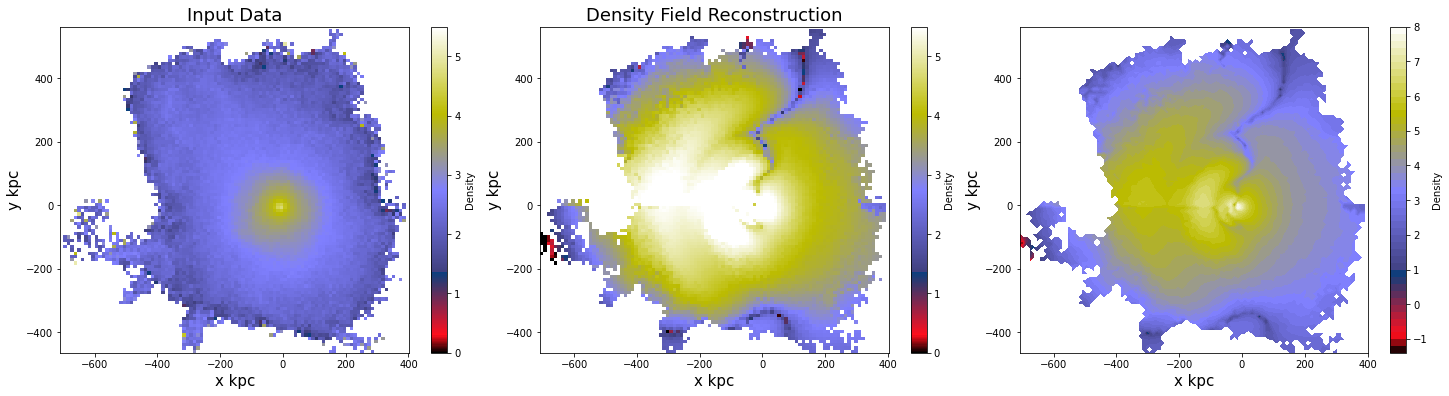

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(25,6))
extent = xb.min(),xb.max(),yb.min(),yb.max()
im = ax[0].imshow(np.log10( Hden*(rbins[-1]**2/Macc[-1]) ),extent=extent,aspect='auto',origin='lower',interpolation='none',cmap='gist_stern')
plt.colorbar(im, ax=ax[0],label='Density')
ax[0].set_title('Input Data',fontsize=18)
im.set_clim(0,5.5)
#im2 = ax[1].contourf(xgrid, ygrid, np.log10(np.abs(den_mon + den_nonmon)),40,cmap='gist_stern')
im2 = ax[1].imshow(np.log10(np.abs(den_mon + den_nonmon)),extent=extent,aspect='auto',origin='lower',interpolation='none',cmap='gist_stern')
plt.colorbar(im2, ax=ax[1],label='Density')
ax[1].set_title('Density Field Reconstruction',fontsize=18)
im2.set_clim(0,5.5)
maskden = Hden==0
denmask =  np.copy(np.log10(np.abs(den_mon + den_nonmon)))
denmask[maskden] =  np.nan
#im3 = ax[2].imshow(denmask,extent=extent,aspect='auto',origin='lower',interpolation='none',cmap='gist_stern')
im3 = ax[2].contourf(xgrid, ygrid, denmask,50,cmap='gist_stern')
plt.colorbar(im3, ax=ax[2],label='Density')

for i_ in [0,1,2]:
    ax[i_].set_xlabel('x kpc',fontsize=15)
    ax[i_].set_ylabel('y kpc',fontsize=15)
plt.subplots_adjust(wspace=0.1)
plt.show()
plt.close()

/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


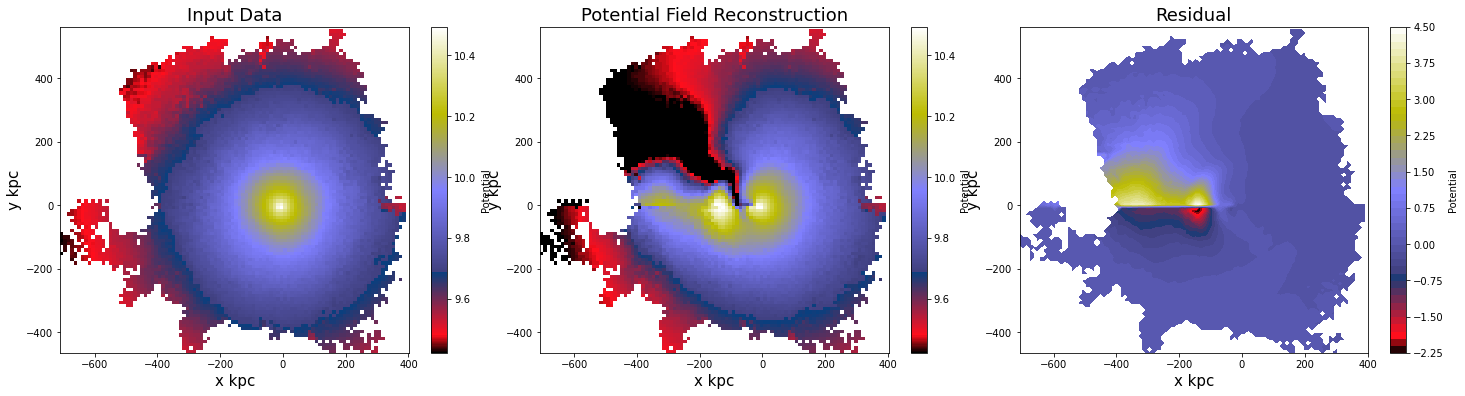

In [20]:
km2kpc=3.24078e-17

Hpot_= np.log10(np.abs( Hpotmed))#* (rbins[-1]/(G*Macc[-1]) )    ))

fig, ax = plt.subplots(1, 3, figsize=(25,6))
extent = xb.min(),xb.max(),yb.min(),yb.max()
im = ax[0].imshow(Hpot_,extent=extent,aspect='auto',origin='lower',interpolation='none',cmap='gist_stern')
plt.colorbar(im, ax=ax[0],label='Potential')
#im.set_clim(7,12)
ax[0].set_title('Input Data',fontsize=18)
#*(rbins[-1]/(Macc[-1]) ) 
#im2 = ax[1].contourf(xgrid, ygrid, np.log10(np.abs(den_mon + den_nonmon)),40,cmap='gist_stern')
im2 = ax[1].imshow(np.log10(np.abs(pot_mon + pot_nonmon)),extent=extent,aspect='auto',origin='lower',interpolation='none',cmap='gist_stern')
plt.colorbar(im2, ax=ax[1],label='Potential')
im2.set_clim(im.get_clim()[0],im.get_clim()[1])
ax[1].set_title('Potential Field Reconstruction',fontsize=18)


potresidual = (Hpotmed - (pot_mon + pot_nonmon))/Hpotmed

#im3 = ax[2].imshow(denmask,extent=extent,aspect='auto',origin='lower',interpolation='none',cmap='gist_stern')
im3 = ax[2].contourf(xgrid, ygrid, potresidual,50,cmap='gist_stern')
plt.colorbar(im3, ax=ax[2],label='Potential')
#im3.set_clim(7,12)
for i_ in [0,1,2]:
    ax[i_].set_xlabel('x kpc',fontsize=15)
    ax[i_].set_ylabel('y kpc',fontsize=15)
plt.subplots_adjust(wspace=0.1)
ax[2].set_title('Residual',fontsize=18)
plt.show()
plt.close()


In [21]:
im.get_clim()

(9.422540487013194, 10.493792397329123)

### Diferences
#### Logaritmic

In [22]:
potdiff = (Hpot* km2kpc**2 * (rbins[-1]/(G*Macc[-1]) ))  - (pot_mon + pot_nonmon)
potdiff[maskpot] = np.nan
fig, ax = plt.subplots(1, 2, figsize=(15,6))
extent = x.min(),x.max(),y.min(),y.max()
im = ax[0].imshow(np.log10(np.abs(Hden*(rbins[-1]**2/Macc[-1]) - 10**denmask)),extent=extent,aspect='auto',origin='lower',interpolation='none',cmap='brg')
plt.colorbar(im, ax=ax[0],label='Density')
ax[0].set_title('Density',fontsize=18)

#im2 = ax[1].contourf(xgrid, ygrid, np.log10(np.abs(den_mon + den_nonmon)),40,cmap='gist_stern')
im2 = ax[1].imshow(np.log10(np.abs(potdiff)),extent=extent,aspect='auto',origin='lower',interpolation='none',cmap='brg')
plt.colorbar(im2, ax=ax[1],label='Density')
ax[1].set_title('Potential',fontsize=18)


for i_ in [0,1]:
    ax[i_].set_xlabel('x kpc',fontsize=15)
    ax[i_].set_ylabel('y kpc',fontsize=15)
plt.subplots_adjust(wspace=0.1)
plt.show()
plt.close()

NameError: name 'maskpot' is not defined

#### Linear

In [ ]:
potdiff = (Hpot* km2kpc**2 * (rbins[-1]/(G*Macc[-1]) ))  - (pot_mon + pot_nonmon)
potdiff[maskpot] = np.nan
fig, ax = plt.subplots(1, 2, figsize=(15,6))
extent = x.min(),x.max(),y.min(),y.max()
im = ax[0].imshow((Hden*(rbins[-1]**2/Macc[-1]) - 10**denmask)/(Hden*(rbins[-1]**2/Macc[-1])),extent=extent,aspect='auto',origin='lower',interpolation='none',cmap='brg')
plt.colorbar(im, ax=ax[0],label='Density')
ax[0].set_title('Density',fontsize=18)
im.set_clim(0,1)
#im2 = ax[1].contourf(xgrid, ygrid, np.log10(np.abs(den_mon + den_nonmon)),40,cmap='gist_stern')
im2 = ax[1].imshow(potdiff,extent=extent,aspect='auto',origin='lower',interpolation='none',cmap='brg')
plt.colorbar(im2, ax=ax[1],label='Density')
ax[1].set_title('Potential',fontsize=18)


for i_ in [0,1]:
    ax[i_].set_xlabel('x kpc',fontsize=15)
    ax[i_].set_ylabel('y kpc',fontsize=15)
plt.subplots_adjust(wspace=0.1)
plt.show()
plt.close()